1. The first thing to do is to import necessary libraries. Let's import pandas and numpy using correct aliases.

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

2. Loading in the titanic dataset to a Pandas DataFrame named `titanic_df`:

In [61]:
titanic_df = pd.read_csv('titanic.csv')

3. We want to inspect the dataframe to see what column we have, data types for each feature, and nulls:

In [62]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 895 entries, 0 to 894
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  895 non-null    int64  
 1   Survived     895 non-null    int64  
 2   Pclass       895 non-null    int64  
 3   Name         895 non-null    object 
 4   Sex          895 non-null    object 
 5   Age          716 non-null    float64
 6   SibSp        895 non-null    int64  
 7   Parch        895 non-null    int64  
 8   Ticket       895 non-null    object 
 9   Fare         895 non-null    float64
 10  Cabin        205 non-null    object 
 11  Embarked     893 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 84.0+ KB


There are nulls in three columns:
- Age
- Cabin
- Embarked

We will have to deal with these.

4. A quick inspection of the column names reveal that we might want to rename these columns so that it is more explicit as to what they mean. Some column names to consider renaming are:
- Pclass to 'Passenger_Class'
- SibSp to 'Sibling_Spouse_Count'
- Parch to 'Parents_Children_Count'

In [63]:
titanic_df.rename(columns={'Pclass': 'Passenger_Class', 'SibSp': 'Sibling_Spouse_Count', 'Parch': 'Parents_Children_Count'}, inplace=True)
titanic_df.columns

Index(['PassengerId', 'Survived', 'Passenger_Class', 'Name', 'Sex', 'Age',
       'Sibling_Spouse_Count', 'Parents_Children_Count', 'Ticket', 'Fare',
       'Cabin', 'Embarked'],
      dtype='object')

5. Inspect distibution in the `Cabin` column.

In [64]:
titanic_df['Cabin'].value_counts()

Cabin
B96 B98        4
G6             4
C23 C25 C27    4
E101           3
F33            3
              ..
C32            1
E34            1
C7             1
C54            1
C148           1
Name: count, Length: 147, dtype: int64

6. Get the number of nulls in the `Cabin` column:

In [65]:
titanic_df['Cabin'].isna().sum()

690

6. The .value_counts() and the null counting tells us that:
    a) the category is too granular and the mode is not sufficiently dominant to impute with
    b) the vast majority of the column are nulls

This is a case where imputation would lead to severe data skewing. It is best just to drop this column. Let's do it:

In [66]:
titanic_df.drop(columns= ['Cabin'], inplace=True)
titanic_df.columns

Index(['PassengerId', 'Survived', 'Passenger_Class', 'Name', 'Sex', 'Age',
       'Sibling_Spouse_Count', 'Parents_Children_Count', 'Ticket', 'Fare',
       'Embarked'],
      dtype='object')

7. Before doing any kind of statistical imputation, it is good to check if you have any duplicates in your data. Significant duplicates can skew imputations based off calculated statistics, so let's take care of this first. Create a boolean mask and filter to return any duplicated rows as a DataFrame:

In [67]:
titanic_df[titanic_df.duplicated()]

,PassengerId,Survived,Passenger_Class,Name,Sex,Age,Sibling_Spouse_Count,Parents_Children_Count,Ticket,Fare,Embarked
54,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,S
90,74,0,3,"Chronopoulos, Mr. Apostolos",male,26.0,1,0,2680,14.4542,C
146,141,0,3,"Boulos, Mrs. Joseph (Sultana)",female,NaN,0,2,2678,15.2458,C
625,141,0,3,"Boulos, Mrs. Joseph (Sultana)",female,NaN,0,2,2678,15.2458,C


8. There are some duplicates here. Let's use pandas magic and clean them. We can check if we have any duplicates afterwards:

In [68]:
titanic_df.drop_duplicates(inplace=True)

# this sums over all instances of rows as to whether they are duplicates of another row or not.
titanic_df.duplicated().sum() # gets number of duplicates left after drop duplicate operation

0

We have taken care of any duplicates in the dataframe. Now let's turn to statistical imputation tasks.

9. Let's take a look at the Age column. Compute the number of NaNs in Age.

In [69]:
titanic_df['Age'].isna().sum()

177

8. While the column has a significant number of nulls, there are enough non-null values that it might be worth trying to impute. First, compute the following summary statistics on `Age`:
- median
- mean
- standard deviation

In [70]:
print(titanic_df['Age'].median())
print(titanic_df['Age'].mean())
print(titanic_df['Age'].std(ddof=1))

28.0
29.69911764705882
14.526497332334044


10. The mean has been pulled a bit up from the median. Let's see why and the ascertain whether imputing with the mean or the median or possibly some other value might be the best strategy. To do this,  we are going to use matplotlib to get a histogram of the Age. Let's also plot the median and mean as dashed vertical lines colored red and green. 

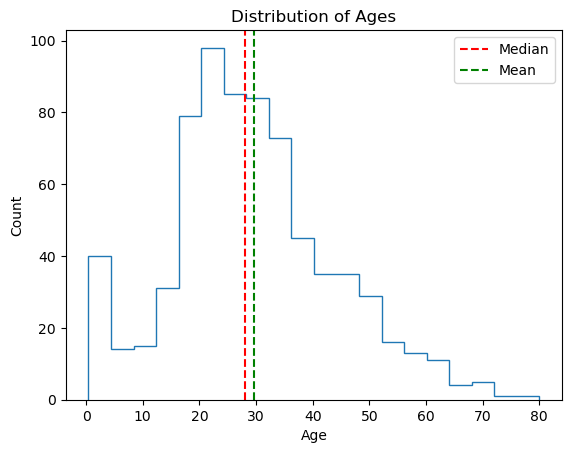

In [71]:
fig, ax = plt.subplots()
ax.hist(x = titanic_df['Age'], histtype='step', bins = 20)
ax.set_xlabel('Age')
ax.set_ylabel('Count')
ax.set_title('Distribution of Ages')
ax.axvline(titanic_df['Age'].median(), c = 'r', linestyle = '--', label = 'Median')
ax.axvline(titanic_df['Age'].mean(), c = 'g', linestyle = '--', label = 'Mean')
ax.legend()
plt.show()

11. The distribution clearly has a range of age values (~20-40) that dominate the distribution. It is a decent bet that if we impute with a good value of central tendency, our imputed value might not be too far off from the true, unknown value. The median looks like a better measure of central tendency than the mean. This is due to the skew at higher ages (> 40). Let's impute with the median:

In [72]:
titanic_df['Age'] = titanic_df['Age'].fillna(titanic_df['Age'].median())

12. Calculate the new mean and standard deviation. Compare the old mean and standard deviation above with the new mean and standard deviation. What happened?

In [73]:
print(titanic_df['Age'].mean())
print(titanic_df['Age'].std(ddof = 1))

29.36158249158249
13.019696550973194


We impute with all 179 null values with the median. This had the effect of pulling the mean down and lowering the standard deviation -- as the median is lower than the mean and the imputed nulls all have the same value. **Be aware that simple imputation alters summary statistics.**

13. Print the unique categories and value counts for `Embarked`:

In [76]:
print(titanic_df['Embarked'].unique())
print(titanic_df['Embarked'].value_counts())

['S' 'C' 'Q' nan]
Embarked
S    644
C    168
Q     77
Name: count, dtype: int64


This distribution is completely dominated by the category `S` -- i.e. those who embarked from Southampton. There are only 2 nulls in this column. We could drop the corresponding rows and not lose too much data. But given the clear mode in `Embarked` it might be a good bet that these individuals came from Southampton. Imputation is nice becuse we retain all the data contained in the other columns. Let's code out both strategies:

14. Return a new dataframe with all rows with nulls in `Embarked`. Save it to the variable `mod_df`. **Do not modify the original dataframe in-place.** Then inspect the new dataframe with the .info() method

In [77]:
mod_df = titanic_df.dropna(subset=['Embarked'])
mod_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 0 to 894
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PassengerId             889 non-null    int64  
 1   Survived                889 non-null    int64  
 2   Passenger_Class         889 non-null    int64  
 3   Name                    889 non-null    object 
 4   Sex                     889 non-null    object 
 5   Age                     889 non-null    float64
 6   Sibling_Spouse_Count    889 non-null    int64  
 7   Parents_Children_Count  889 non-null    int64  
 8   Ticket                  889 non-null    object 
 9   Fare                    889 non-null    float64
 10  Embarked                889 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 83.3+ KB


There are no nulls left in the DataFrame. 

15. Now let's try and impute with the mode in the original dataframe. FirstuUse the mode function on the `Embarked` column in `titanic_df`.

In [89]:
titanic_df['Embarked'].mode()

0    S
Name: Embarked, dtype: object

Notice this is  Series -- there can be more than one mode. Let's extract the first value in this series and save it to a variable `embarked_mode`.

In [90]:
embarked_mode = titanic_df['Embarked'].mode().iloc[0]
embarked_mode


'S'

16. Now we impute with the `embarked_mode` in the original dataframe `titanic_df` and inspect the dataframe:

In [92]:
titanic_df['Embarked'] = titanic_df['Embarked'].fillna(embarked_mode)
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 0 to 894
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PassengerId             891 non-null    int64  
 1   Survived                891 non-null    int64  
 2   Passenger_Class         891 non-null    int64  
 3   Name                    891 non-null    object 
 4   Sex                     891 non-null    object 
 5   Age                     891 non-null    float64
 6   Sibling_Spouse_Count    891 non-null    int64  
 7   Parents_Children_Count  891 non-null    int64  
 8   Ticket                  891 non-null    object 
 9   Fare                    891 non-null    float64
 10  Embarked                891 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 83.5+ KB


17. We now have no nulls and have retained the two rows with nulls in `Embarked`. Our data is now ready for further exploratory data analysis. Let's save the cleaned data to csv data. Call the file `cleaned_titanic.csv`

In [94]:
titanic_df.to_csv('clean_titanic.csv')